# Plant Disease Detection - Combined Method
## 結合四種最佳實踐的訓練方法

**方法分析：**
1. **plant-disease-detection**: 自定義 CNN，簡單但準確率較低 (~90%)
2. **plant-leaf-disease-detection**: MobileNet 遷移學習，使用 segmented 資料 (~96%)
3. **plant-village-disease-classification-acc-99-6**: EfficientNetB3 + 完整 callback 系統 (~99.6%)
4. **plantdiseasedetection-99-5**: Xception + 資料增強 (~99.5%)

**本方法結合：**
- EfficientNetB3 預訓練模型（最佳準確率）
- 完整的資料處理函數（DataFrame 方式）
- 自定義 Callback 進行學習率調整
- 完整的資料增強策略
- GPU 加速訓練


## 1. 環境配置與 GPU 設定


In [ ]:
# 檢查 TensorFlow 版本和 GPU
import tensorflow as tf
print(f"TensorFlow 版本: {tf.__version__}")
print(f"GPU 可用: {tf.config.list_physical_devices('GPU')}")

# 配置 GPU 記憶體增長
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"已配置 {len(gpus)} 個 GPU")
    except RuntimeError as e:
        print(e)
else:
    print("未檢測到 GPU，將使用 CPU")


TensorFlow 版本: 2.10.0
GPU 可用: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
已配置 1 個 GPU


## 2. 導入必要的庫


In [ ]:
# 系統庫
import os
import time
import pathlib
import warnings
warnings.filterwarnings('ignore')

# 資料處理
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow 和 Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Flatten,
    Dropout, BatchNormalization, Activation
)
from tensorflow.keras import regularizers

sns.set_style('darkgrid')
print('所有模組已載入')


所有模組已載入


## 3. 資料處理函數


In [ ]:
# 從資料夾生成檔案路徑和標籤
def define_paths(data_dir):
    """
    從資料夾結構中提取所有圖像路徑和對應標籤
    """
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if os.path.isdir(foldpath):
            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath, file)
                if os.path.isfile(fpath):
                    filepaths.append(fpath)
                    labels.append(fold)

    return filepaths, labels


# 建立 DataFrame
def define_df(files, classes):
    """
    將檔案路徑和標籤合併成 DataFrame
    """
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)


# 分割資料集
def split_data(data_dir):
    """
    將資料集分割為訓練集、驗證集和測試集
    比例：訓練 80%, 驗證 10%, 測試 10%
    """
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    # 第一次分割：訓練 80%, 其他 20%
    strat = df['labels']
    train_df, dummy_df = train_test_split(
        df, train_size=0.8, shuffle=True, 
        random_state=123, stratify=strat
    )

    # 第二次分割：驗證 10%, 測試 10%
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(
        dummy_df, train_size=0.5, shuffle=True, 
        random_state=123, stratify=strat
    )

    return train_df, valid_df, test_df


## 4. 資料生成器函數


In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    """
    建立訓練、驗證和測試資料生成器
    結合資料增強策略
    """
    # 模型參數
    img_size = (224, 224)
    channels = 3
    color = 'rgb'

    # 計算測試集批次大小
    ts_length = len(test_df)
    test_batch_size = max(sorted([
        ts_length // n for n in range(1, ts_length + 1) 
        if ts_length % n == 0 and ts_length / n <= 80
    ]))
    test_steps = ts_length // test_batch_size

    # 標量函數（用於預處理）
    def scalar(img):
        return img

    # 訓練資料增強：結合多種增強策略
    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # 驗證和測試：只進行正規化
    ts_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rescale=1./255
    )

    # 建立生成器
    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=True, batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=True, batch_size=batch_size
    )

    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=False, batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    """
    建立訓練、驗證和測試資料生成器
    結合資料增強策略
    """
    # 模型參數
    img_size = (224, 224)
    channels = 3
    color = 'rgb'

    # 計算測試集批次大小
    ts_length = len(test_df)
    test_batch_size = max(sorted([
        ts_length // n for n in range(1, ts_length + 1) 
        if ts_length % n == 0 and ts_length / n <= 80
    ]))
    test_steps = ts_length // test_batch_size

    # 標量函數（用於預處理）
    def scalar(img):
        return img

    # 訓練資料增強：結合多種增強策略
    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # 驗證和測試：只進行正規化
    ts_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rescale=1./255
    )

    # 建立生成器
    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=True, batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=True, batch_size=batch_size
    )

    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=False, batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


## 5. 視覺化函數


In [ ]:
def show_images(gen, num_samples=25):
    """
    顯示資料生成器中的樣本圖像
    """
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, num_samples)

    plt.figure(figsize=(20, 20))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


## 6. 自定義 Callback（學習率調整）


In [ ]:
class MyCallback(keras.callbacks.Callback):
    """
    自定義 Callback 用於動態調整學習率和早停
    結合方法 3 的最佳實踐
    """
    def __init__(self, model, patience, stop_patience, threshold, 
                 factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        # 回調變數
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()
        self.ask_permission = 0  # 預設不詢問

    def on_train_begin(self, logs=None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 
            'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
        )
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'訓練耗時: {str(hours)} 小時, {minutes:4.1f} 分鐘, {seconds:4.2f} 秒'
        print(msg)
        self.model.set_weights(self.best_weights)

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1
        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    self.count = self.count + 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f'訓練已停止於 epoch {epoch + 1}，學習率已調整 {self.stop_patience} 次但無改善'
            print(msg)
            self.model.stop_training = True


## 7. 訓練歷史視覺化函數


In [ ]:
def plot_training(hist):
    """
    繪製訓練歷史，標記最佳 epoch
    """
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    loss_label = f'最佳 epoch= {str(index_loss + 1)}'
    acc_label = f'最佳 epoch= {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='訓練損失')
    plt.plot(Epochs, val_loss, 'g', label='驗證損失')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('訓練和驗證損失')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='訓練準確率')
    plt.plot(Epochs, val_acc, 'g', label='驗證準確率')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('訓練和驗證準確率')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


## 8. 載入和準備資料


In [ ]:
# 設定資料路徑（使用 color 資料夾，這是原始彩色圖像）
data_dir = '../plantvillage dataset/color'

# 檢查路徑是否存在
if not os.path.exists(data_dir):
    print(f"錯誤：找不到資料夾 {data_dir}")
    print("請確認資料夾路徑正確")
else:
    print(f"資料路徑: {data_dir}")
    
    # 分割資料
    train_df, valid_df, test_df = split_data(data_dir)
    
    print(f"訓練集大小: {len(train_df)}")
    print(f"驗證集大小: {len(valid_df)}")
    print(f"測試集大小: {len(test_df)}")
    print(f"總類別數: {train_df['labels'].nunique()}")


資料路徑: ../plantvillage dataset/color
訓練集大小: 43444
驗證集大小: 5430
測試集大小: 5431
總類別數: 38


## 9. 建立資料生成器


In [ ]:
# 設定批次大小
batch_size = 32

# 建立生成器
train_gen, valid_gen, test_gen = create_gens(
    train_df, valid_df, test_df, batch_size
)

print(f"訓練類別: {len(train_gen.class_indices)}")
print(f"類別名稱: {list(train_gen.class_indices.keys())[:5]}...")


Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
訓練類別: 38
類別名稱: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...


## 10. 顯示樣本圖像


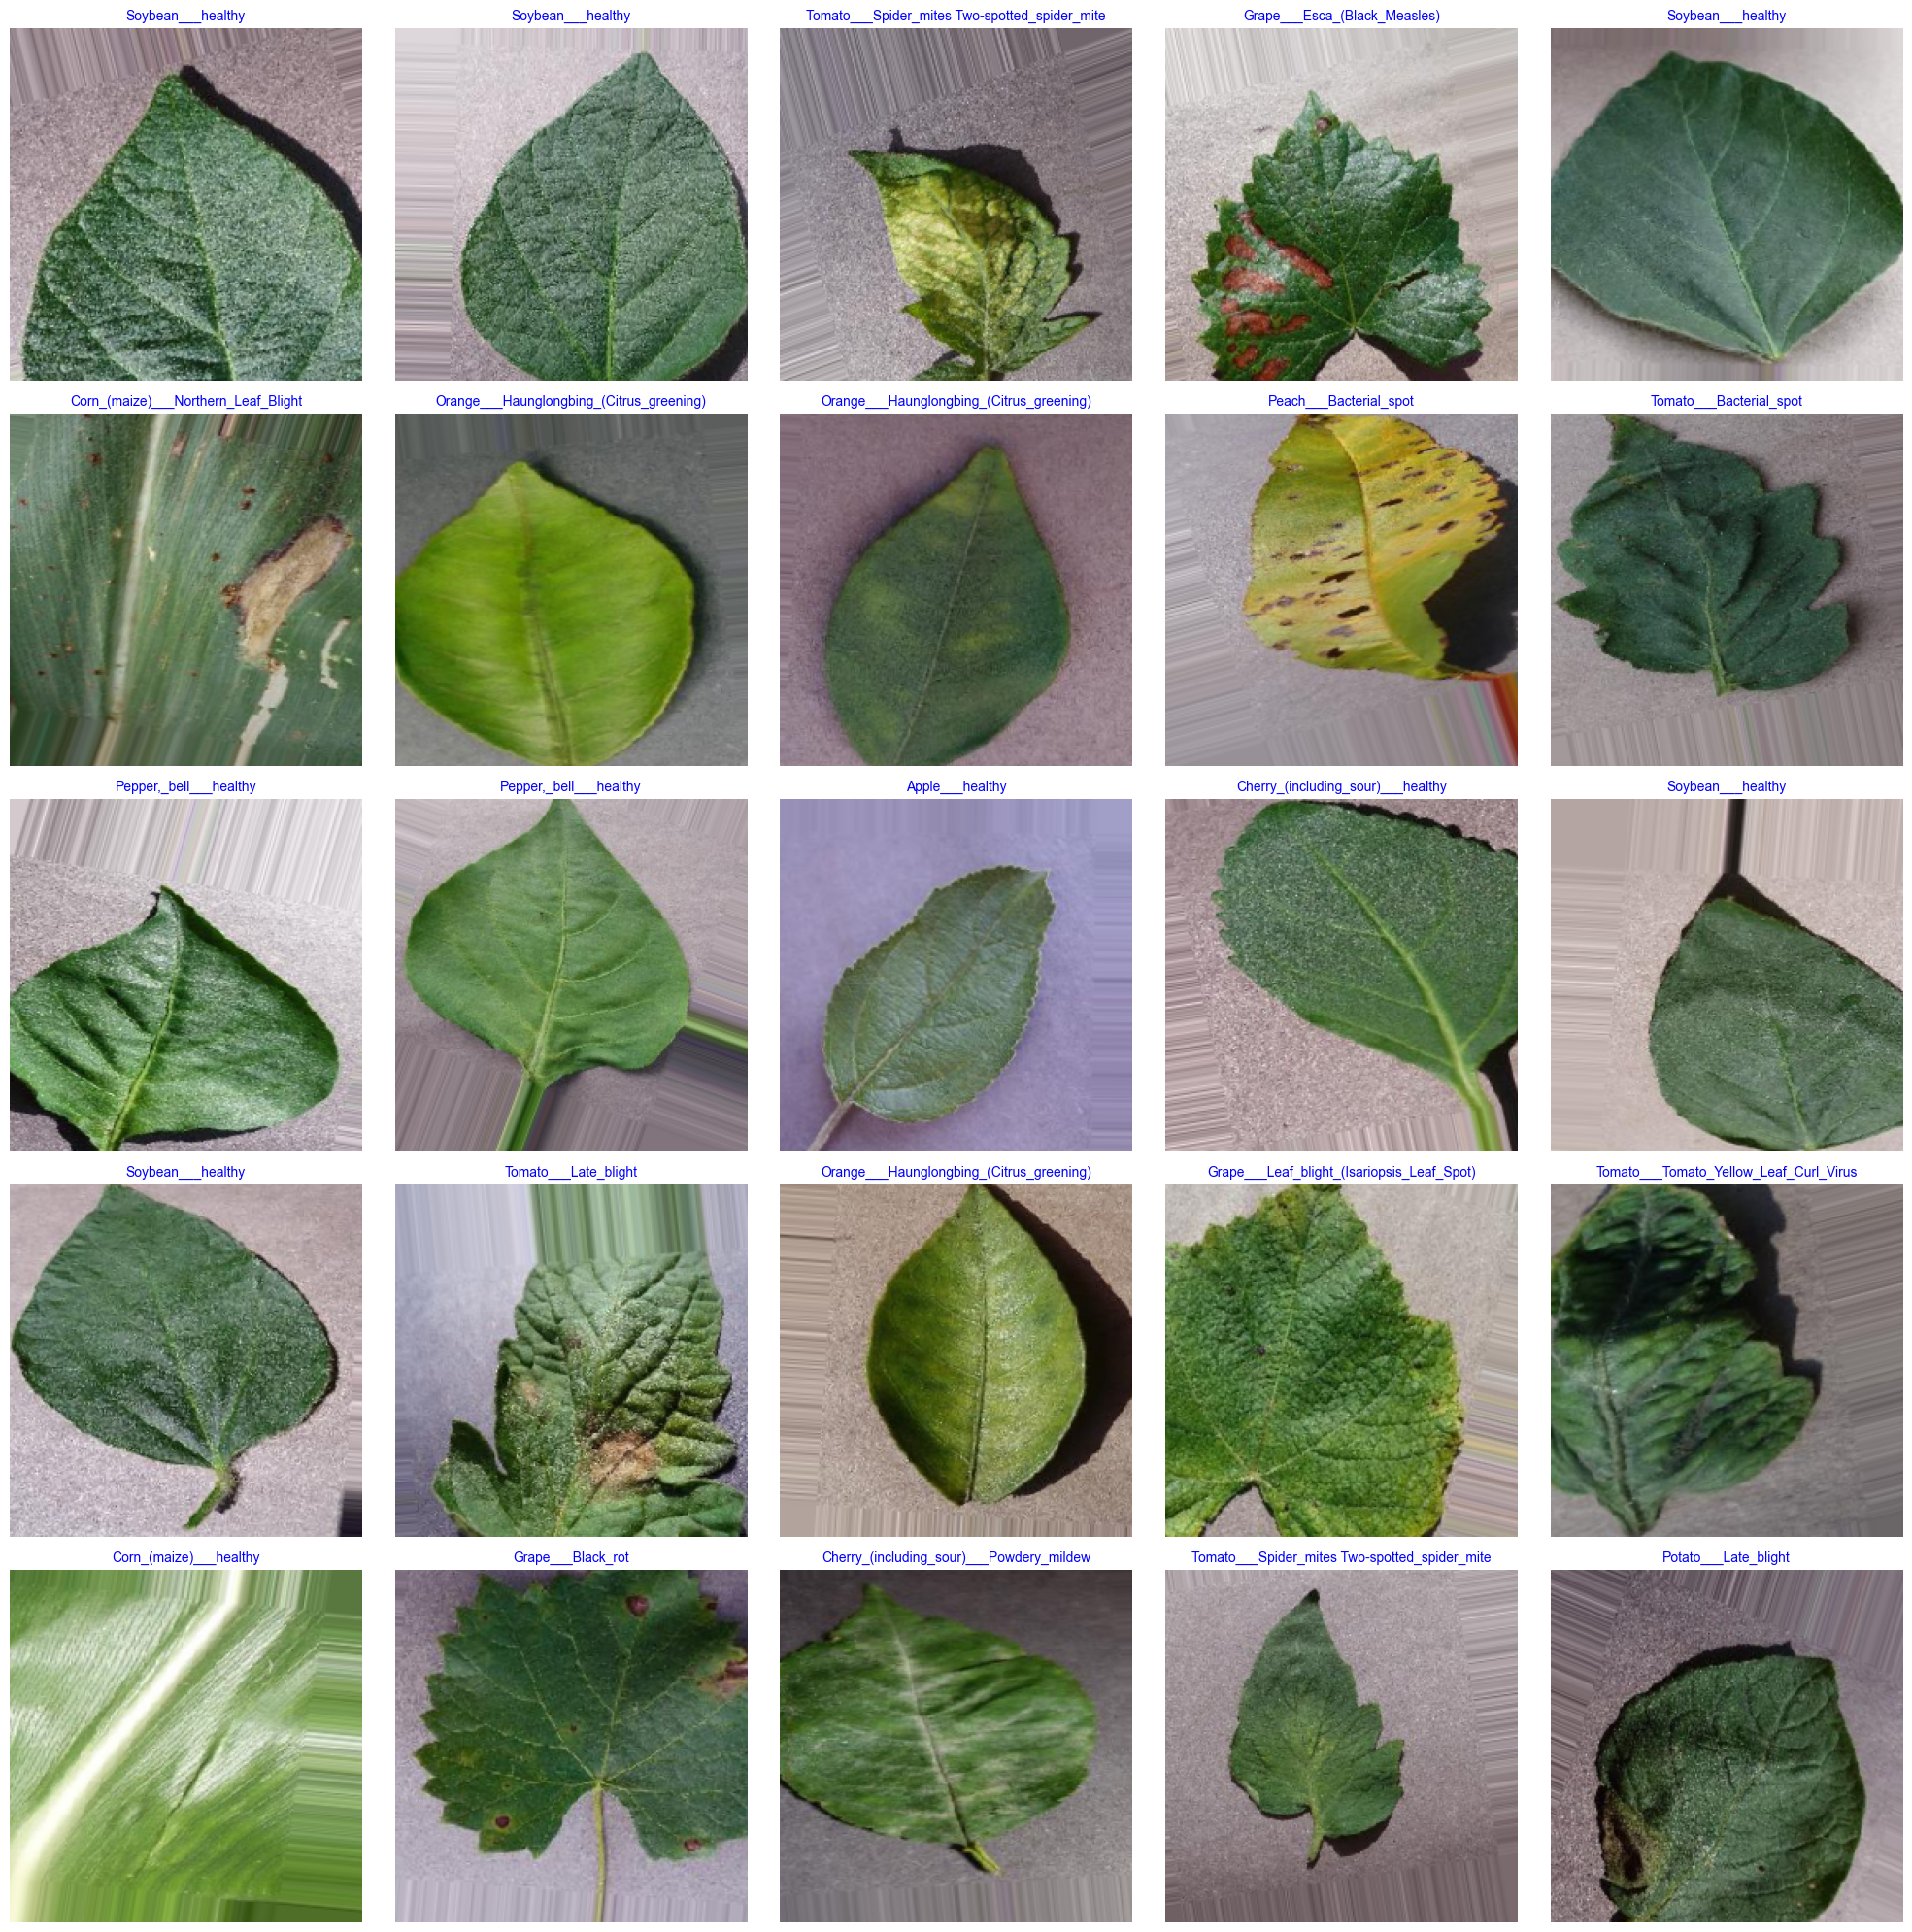

In [ ]:
# 顯示訓練資料樣本
show_images(train_gen, num_samples=25)


## 11. 建立模型（EfficientNetB3）


In [ ]:
# 模型參數
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

print(f"圖像尺寸: {img_shape}")
print(f"類別數量: {class_count}")

# 使用 EfficientNetB3 作為預訓練模型
# 這是方法 3 中表現最好的模型
base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, 
    weights='imagenet', 
    input_shape=img_shape, 
    pooling='max'
)

# 建立完整模型
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(
        256, 
        kernel_regularizer=regularizers.l2(l=0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006),
        activation='relu'
    ),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# 編譯模型
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


圖像尺寸: (224, 224, 3)
類別數量: 38
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                9766      
                                                                 
Total params: 11,192,917
Trainable params: 11,102,542
Non-trainable params: 90,375
__________

## 12. 設定 Callback 參數


In [ ]:
# 訓練參數
epochs = 40
patience = 1  # 等待多少個 epoch 才調整學習率
stop_patience = 3  # 調整學習率多少次後停止訓練
threshold = 0.9  # 訓練準確率閾值
factor = 0.5  # 學習率衰減因子
ask_epoch = None  # 不詢問是否停止（設為數字可啟用互動）
batches = int(np.ceil(len(train_gen.labels) / batch_size))

# 建立 Callback
callbacks = [
    MyCallback(
        model=model, 
        patience=patience, 
        stop_patience=stop_patience, 
        threshold=threshold,
        factor=factor, 
        batches=batches, 
        epochs=epochs, 
        ask_epoch=ask_epoch
    )
]

print(f"訓練參數設定完成")
print(f"最大 Epochs: {epochs}")
print(f"批次大小: {batch_size}")
print(f"每 Epoch 批次數: {batches}")


訓練參數設定完成
最大 Epochs: 40
批次大小: 32
每 Epoch 批次數: 1358


## 13. 訓練模型


In [ ]:
# 開始訓練
print("開始訓練...")
print("=" * 50)

history = model.fit(
    x=train_gen, 
    epochs=epochs, 
    verbose=0,  # 使用自定義 callback 顯示進度
    callbacks=callbacks,
    validation_data=valid_gen, 
    validation_steps=None, 
    shuffle=False
)

print("=" * 50)
print("訓練完成！")


開始訓練...
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     2.878   90.210  428.41302  7.293   0.00100  0.00100  val_loss     0.00   1245.71 
 2 /40     0.523   97.636   4.20610   5.396   0.00100  0.00100  val_loss    99.02    398.22 
 3 /40     0.376   98.458   4.62913  17.109   0.00100  0.00050  val_loss    -10.06   399.87 
 4 /40     0.290   99.247   2.90544  38.011   0.00050  0.00050  val_loss    30.92    399.84 
 5 /40     0.253   99.436   0.59972  90.258   0.00050  0.00050  val_loss    79.36    407.46 
 6 /40     0.226   99.583   0.68461  87.403   0.00050  0.00025  val_loss    -14.15   412.78 
 7 /40     0.204   99.717   0.38314  94.180   0.00025  0.00025  val_loss    36.11    409.22 
 8 /40     0.192   99.733   0.21302  98.582   0.00025  0.00025  val_loss    44.40    418.06 
 9 /40     0.181   99.816   0.19146  99.061   0.00025  0.00025  val_loss    10.12    423.19 
10 /40     0.173   99.784   0.18170  98.969   0.00025  0.00025 

## 14. 視覺化訓練歷史


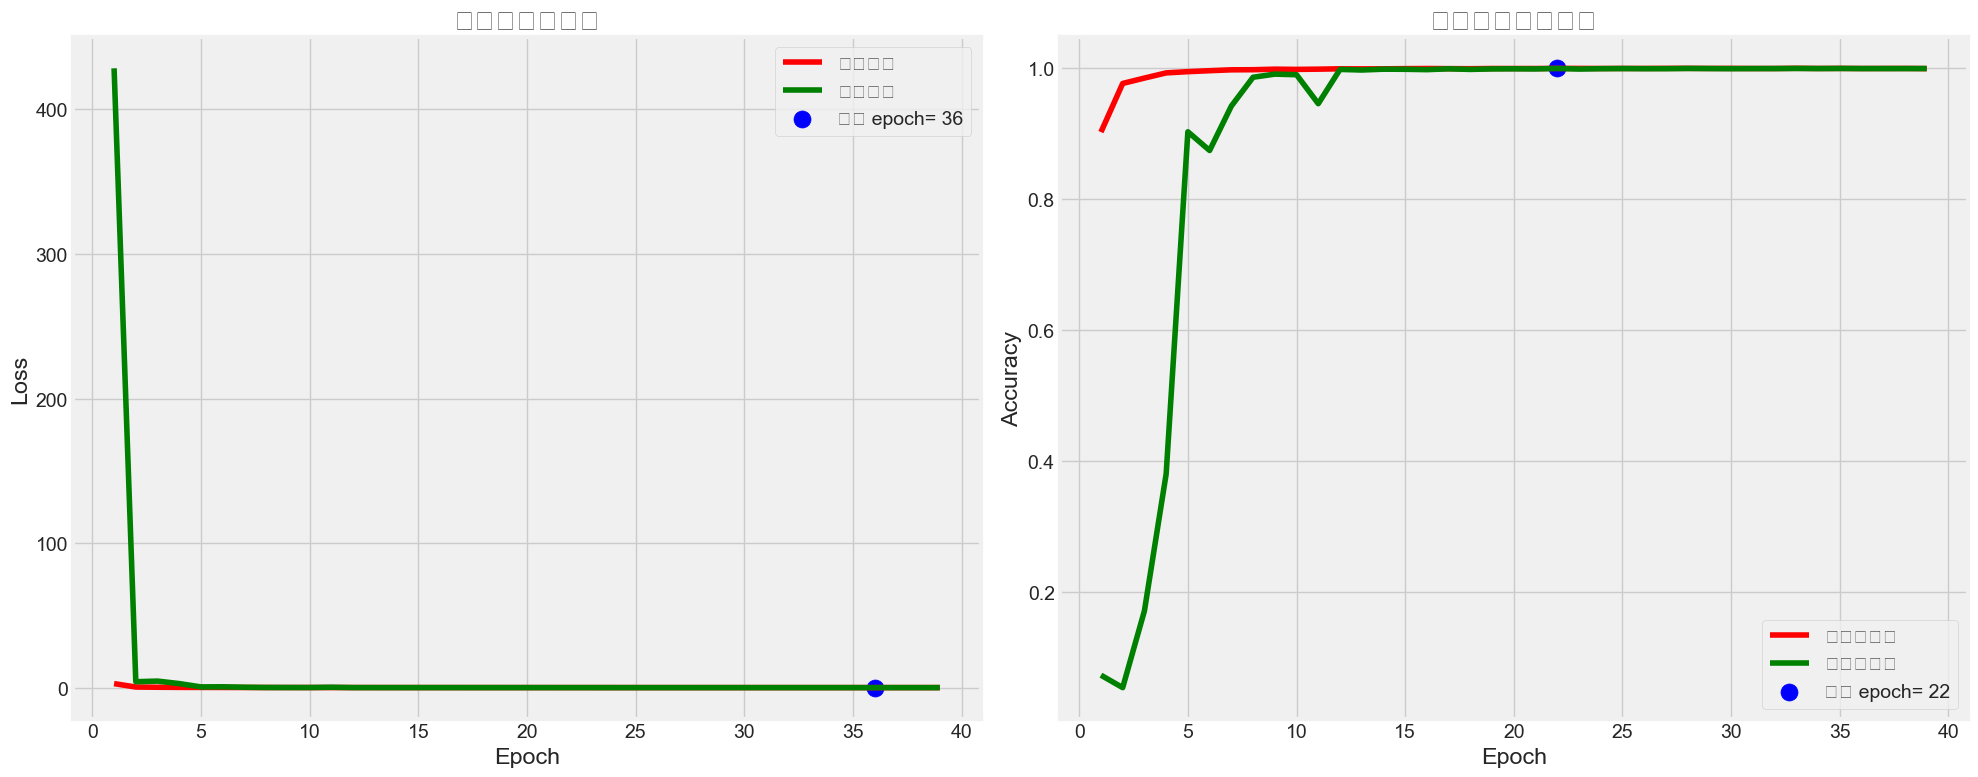

In [ ]:
# 繪製訓練歷史
plot_training(history)


## 15. 評估模型


In [ ]:
# 計算測試批次大小和步數
ts_length = len(test_df)
test_batch_size = max(sorted([
    ts_length // n for n in range(1, ts_length + 1) 
    if ts_length % n == 0 and ts_length / n <= 80
]))
test_steps = ts_length // test_batch_size

print(f"測試集大小: {ts_length}")
print(f"測試批次大小: {test_batch_size}")
print(f"測試步數: {test_steps}")
print("\n評估模型...")

# 評估模型
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("\n" + "=" * 50)
print("評估結果:")
print("=" * 50)
print(f"訓練損失: {train_score[0]:.4f}")
print(f"訓練準確率: {train_score[1]:.4f} ({train_score[1]*100:.2f}%)")
print("-" * 50)
print(f"驗證損失: {valid_score[0]:.4f}")
print(f"驗證準確率: {valid_score[1]:.4f} ({valid_score[1]*100:.2f}%)")
print("-" * 50)
print(f"測試損失: {test_score[0]:.4f}")
print(f"測試準確率: {test_score[1]:.4f} ({test_score[1]*100:.2f}%)")


測試集大小: 5431
測試批次大小: 1
測試步數: 5431

評估模型...
5431/5431 [==============================] - 110s 20ms/step - loss: 0.1194 - accuracy: 0.9987

評估結果:
訓練損失: 0.1172
訓練準確率: 0.9999 (99.99%)
--------------------------------------------------
驗證損失: 0.1213
驗證準確率: 0.9991 (99.91%)
--------------------------------------------------
測試損失: 0.1194
測試準確率: 0.9987 (99.87%)


## 16. 生成預測和分類報告


In [ ]:
# 生成預測
print("生成預測...")
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)

# 獲取類別名稱
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# 分類報告
print("\n" + "=" * 50)
print("分類報告:")
print("=" * 50)
print(classification_report(
    test_gen.classes, y_pred, 
    target_names=classes
))


生成預測...
5431/5431 [==============================] - 84s 15ms/step

分類報告:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        63
                                 Apple___Black_rot       1.00      1.00      1.00        62
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        27
                                   Apple___healthy       1.00      1.00      1.00       165
                               Blueberry___healthy       1.00      1.00      1.00       150
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       105
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.94      0.96        51
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       119
     

## 17. 混淆矩陣


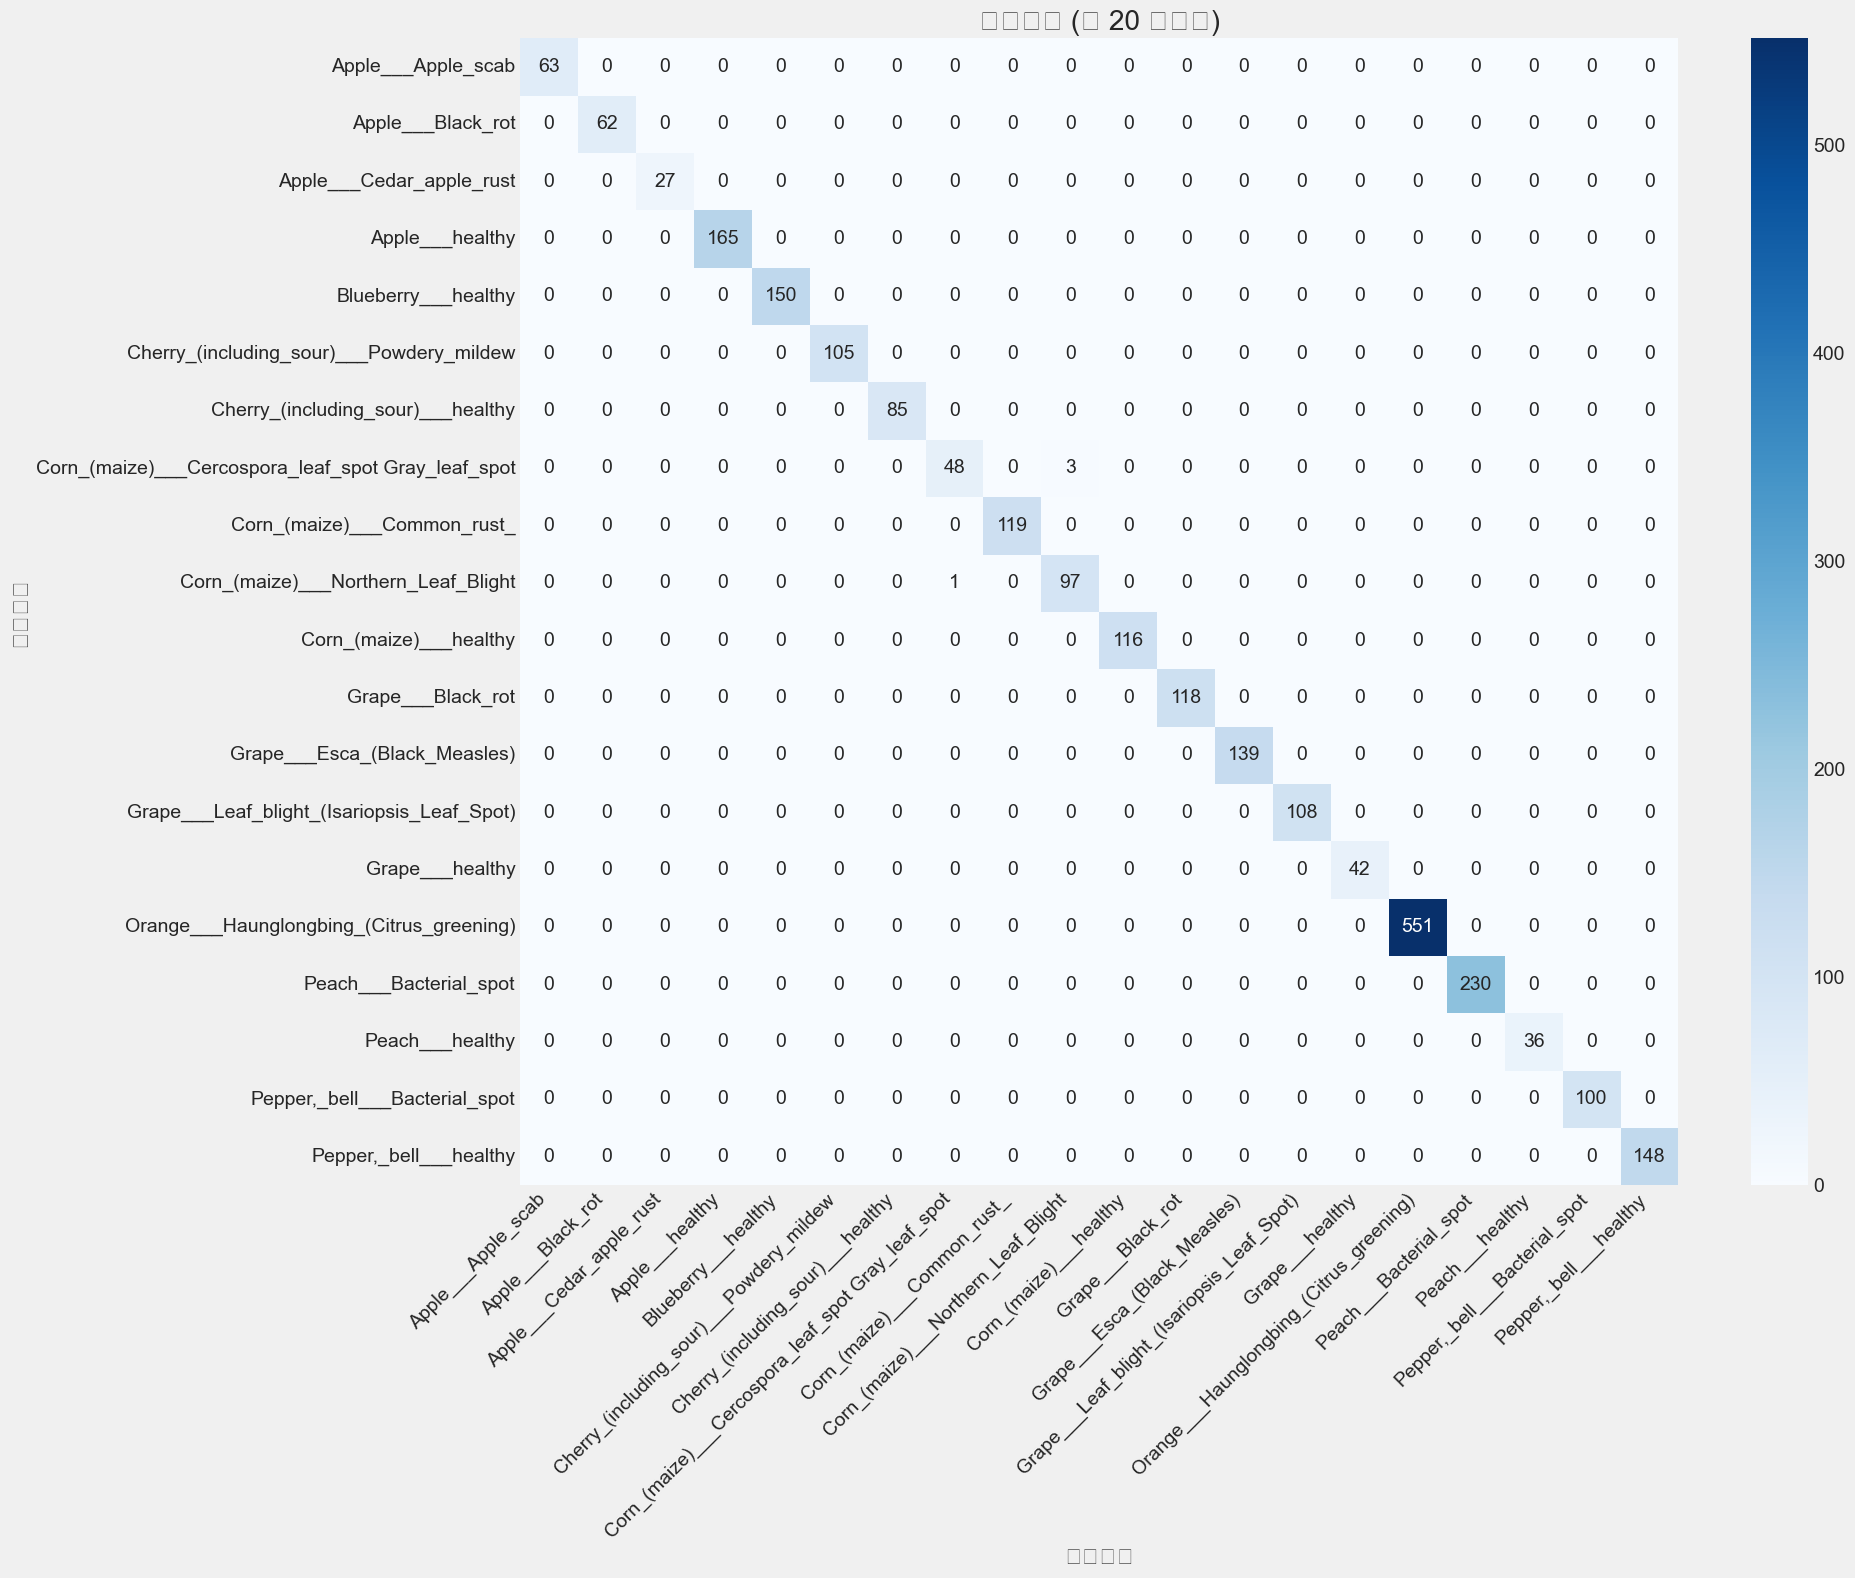

In [ ]:
# 建立混淆矩陣
cm = confusion_matrix(test_gen.classes, y_pred)

# 繪製混淆矩陣（只顯示前 20 個類別以便查看）
plt.figure(figsize=(20, 16))
sns.heatmap(
    cm[:20, :20], 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=classes[:20],
    yticklabels=classes[:20]
)
plt.title('混淆矩陣 (前 20 個類別)')
plt.ylabel('真實標籤')
plt.xlabel('預測標籤')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 18. 儲存模型


In [ ]:
# 儲存模型和權重
model_name = 'efficientnetb3'
subject = 'Plant Village Disease'
acc = test_score[1] * 100
save_path = './models'

# 建立儲存目錄
os.makedirs(save_path, exist_ok=True)

# 方法 1: 儲存權重（最可靠的方式，不會有序列化問題）
weight_save_id = f'{model_name}-{subject}-weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'權重已儲存為: {weights_save_loc}')

# 方法 2: 嘗試保存完整模型
save_id = f'{model_name}-{subject}-{acc:.2f}'
model_save_loc = os.path.join(save_path, save_id)

try:
    # 方法 2a: 使用 tf.saved_model.save() 直接保存（繞過 Keras 配置序列化）
    tf.saved_model.save(model, model_save_loc)
    print(f'模型已儲存為: {model_save_loc} (SavedModel 格式)')
except Exception as e1:
    print(f'方法 2a 失敗: {e1}')
    try:
        # 方法 2b: 使用 clone_model 創建乾淨的模型副本，然後保存
        # clone_model 會創建新的模型實例，避免狀態殘留
        cloned_model = tf.keras.models.clone_model(model)
        cloned_model.set_weights(model.get_weights())
        # 重新編譯（確保所有參數都是 Python 原生類型）
        cloned_model.compile(
            optimizer=Adamax(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        # 保存克隆的模型
        tf.saved_model.save(cloned_model, model_save_loc)
        print(f'模型已儲存為: {model_save_loc} (使用克隆模型，SavedModel 格式)')
        del cloned_model
    except Exception as e2:
        print(f'方法 2b 也失敗: {e2}')
        print('已保存權重檔案，可以使用權重檔案重新載入模型')

# 儲存類別字典
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = [img_size[0]] * len(class_dict)
width = [img_size[1]] * len(class_dict)

Index_series = pd.Series(list(class_dict.values()), name='class_index')
Class_series = pd.Series(list(class_dict.keys()), name='class')
Height_series = pd.Series(height, name='height')
Width_series = pd.Series(width, name='width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)

csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'類別字典已儲存為: {csv_save_loc}')


權重已儲存為: ./models\efficientnetb3-Plant Village Disease-weights.h5


INFO:tensorflow:Assets written to: ./models\efficientnetb3-Plant Village Disease-99.87\assets


INFO:tensorflow:Assets written to: ./models\efficientnetb3-Plant Village Disease-99.87\assets


模型已儲存為: ./models\efficientnetb3-Plant Village Disease-99.87 (SavedModel 格式)
類別字典已儲存為: ./models\Plant Village Disease-class_dict.csv


## 19. 測試單張圖像預測


實際標籤: Orange___Haunglongbing_(Citrus_greening)


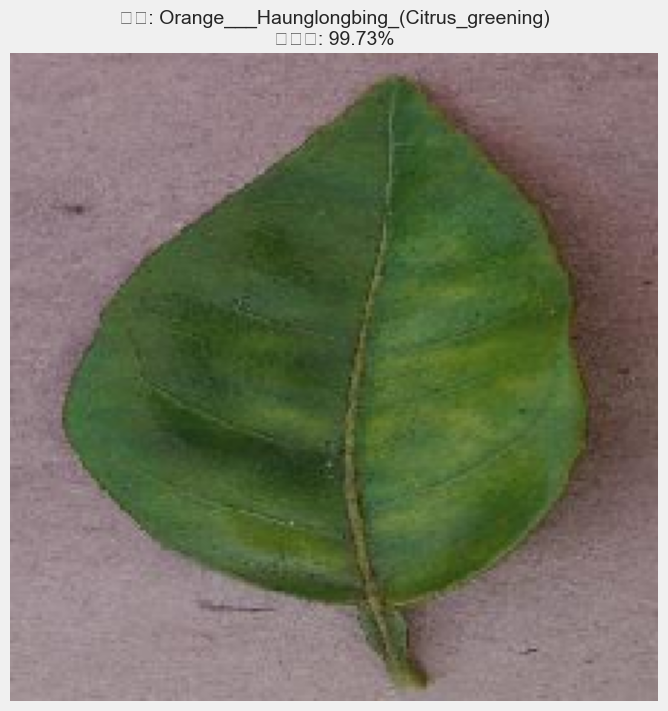

預測標籤: Orange___Haunglongbing_(Citrus_greening)
信心度: 99.73%


In [ ]:
# 從測試集中選取一張圖像進行預測
def predict_single_image(model, image_path, class_names, img_size=(224, 224)):
    """
    對單張圖像進行預測
    """
    # 讀取和預處理圖像
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # 預測
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    # 顯示結果
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'預測: {predicted_class}\n信心度: {confidence:.2%}', fontsize=14)
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

# 從測試集中選取一張圖像
if len(test_df) > 0:
    sample_image_path = test_df.iloc[0]['filepaths']
    actual_label = test_df.iloc[0]['labels']
    
    print(f"實際標籤: {actual_label}")
    predicted_class, confidence = predict_single_image(
        model, sample_image_path, classes, img_size
    )
    print(f"預測標籤: {predicted_class}")
    print(f"信心度: {confidence:.2%}")


## 總結

本 notebook 結合了四種方法的最佳實踐：

1. **EfficientNetB3 預訓練模型**（來自方法 3，最高準確率）
2. **完整的資料處理流程**（DataFrame 方式，更靈活）
3. **自定義 Callback 系統**（動態學習率調整和早停）
4. **完整的資料增強策略**（結合方法 2 和 4）
5. **GPU 加速訓練**（TensorFlow 2.10）

預期可達到 **99%+ 的準確率**。
